In [1]:
import sys,os
sys.path.append("../")

import pandas as pd
import numpy as np
import pickle
import itertools
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances  
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import mutual_info_score
from sklearn.metrics import normalized_mutual_info_score
from sklearn.metrics import completeness_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import v_measure_score


from scipy.stats import entropy
import seaborn as sns

import matplotlib.pyplot as plt
from IPython.display import HTML
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

sns.set()
sns.set_style("darkgrid")

## Reading the change object and clustering.

In [2]:
article_name = "John_Logie_Baird"
change_object_dir =  "../data/change objects/"

change_object_file_name = f"{article_name}_vec.npz"
filename =  f"{article_name}_change.h5"

change_object_file = os.path.join(change_object_dir, filename)

content_dir = "../data/content/"

filename = article_name + ".h5"
filepath = os.path.join(content_dir, filename)
with pd.HDFStore(filepath, 'r') as store:
    token_string_df = store.get("all_tokens")
    
token_string_df = token_string_df.set_index("token_id")["str"]
token_string_df[-1] = "St@rt"
token_string_df[-2] = "$nd"
change_vector_dir = "../data/change_vector/"
change_vec_filename = f"{article_name}.npz"
change_vector_file = os.path.join(change_vector_dir, change_vec_filename)

content_dir = "../data/content/"
len_file = article_name + "_rev_len.h5"
len_file_path = os.path.join(content_dir, len_file)


if os.path.exists(change_object_file):
    with pd.HDFStore(change_object_file, 'r') as store:
        change_object_dataframe = store.get("data")
else:
    print("file do not exist")
    
    


change_object_dataframe["del_string_tokens"] = change_object_dataframe["del_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["ins_string_tokens"] = change_object_dataframe["ins_tokens"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist()))

change_object_dataframe["left_context"] = change_object_dataframe["left_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")

change_object_dataframe["right_context"] = change_object_dataframe["right_token"].apply(
    lambda x:  tuple(token_string_df[np.array(x)].tolist())).str.join(" ")

change_object_dataframe["edit_string_tokens"] = change_object_dataframe["ins_string_tokens"] + change_object_dataframe["del_string_tokens"]


# rev_len_df = pd.read_hdf(len_file_path, key = "rev_len")
vectors ={}

with open(change_vector_file, "rb") as file:
    arrays_dict = np.load(file)
    vectors[2] = arrays_dict["2_clean_not_weighted"]
    vectors[4] = arrays_dict["4_clean_not_weighted"]
#     vectors[6] = arrays_dict["6_clean_not_weighted"]
    vectors[8] = arrays_dict["8_clean_not_weighted"]
    vectors[10] = arrays_dict["10_clean_not_weighted"]
#     vectors[12] = arrays_dict["12_clean_not_weighted"]
    vectors[15] = arrays_dict["15_clean_not_weighted"]
    vectors[20] = arrays_dict["20_clean_not_weighted"]
    vectors[25] = arrays_dict["25_clean_not_weighted"]
    vectors[30] = arrays_dict["30_clean_not_weighted"]

#### read annotations

In [3]:
file_name = article_name + "_FULL.csv"
annotation_dir = "../data/annotation/"
full_file_path = os.path.join(annotation_dir, file_name)
annotation_df = pd.read_csv(full_file_path)
annotation_df = annotation_df[["revid_ctxt", "token_id",
                               "rev_id", "nationality", "birth_place", "Bulk" ]]

### clustering


In [4]:
vector_names = list(vectors.keys())
context_array  = vector_names
eps_array = np.arange(0.25,4.1,0.25)
# [ 0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.2, 1.3, 1.4, 1.5,1.6,1.8,2.0,2.2]

min_samples_array = [2, 5, 10, 20, 30, 50]
all_combinations = list(itertools.product(context_array, eps_array,
                                          min_samples_array))
dbscan_params = list(itertools.product(eps_array,min_samples_array))
idx = pd.MultiIndex.from_product([context_array, eps_array,min_samples_array],
                                names=["context","eps","min_samples"])
cluster_df = pd.DataFrame(columns=idx)

evaluation_df = pd.DataFrame(index=idx, columns=["gap_entropy"])



In [5]:
%%time 
for cluster_by in vector_names:
    distances = pairwise_distances(vectors[cluster_by])
    for eps, min_samples in dbscan_params:
        cluster_df[cluster_by,eps, min_samples] = DBSCAN(eps=eps, min_samples=min_samples, 
                                                         metric="precomputed").fit(distances).labels_

CPU times: user 12min 20s, sys: 3min 24s, total: 15min 44s
Wall time: 8min 10s


In [6]:
def weighted_token_entropy(dataframe, group_by):
    cluster_sizes = dataframe.groupby(group_by).size()
    token_entropy_clusters = dataframe.groupby(group_by)["edit_string_tokens"].apply(
                    lambda token_tuples: entropy(pd.Series(
                    [token for token_tuple in token_tuples.tolist() for token in token_tuple]
                    ).value_counts().values))
    cluster_entropy = (cluster_sizes * token_entropy_clusters).sum()
    return cluster_entropy

In [7]:
cluster_df.index = change_object_dataframe.index
dbscan_results = pd.concat([change_object_dataframe, cluster_df], axis=1)

In [8]:
%%time
# entropy_series = pd.Series(index=all_combinations)

for context, eps, min_samples in all_combinations:
    evaluation_df.loc[(context, eps, min_samples),"gap_entropy"] = weighted_token_entropy(dbscan_results, (context, eps, min_samples))
# all_combinations_without_optimization[0]

CPU times: user 2min 33s, sys: 200 ms, total: 2min 33s
Wall time: 2min 33s


#### Splitting change object to match annotations

In [9]:
# insert array is always done in to revision so taking it and leaving other change object where 
ins_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["ins_start_pos"].values != -1, 
                  ["to revision id","ins_tokens", 'to revision id']].values
ins_cluster = cluster_df.loc[
    change_object_dataframe["ins_start_pos"].values != -1, :]

# delete array is always done in from revision so taking it and leaving other change object where delete does not come.
del_array = change_object_dataframe.reset_index().loc[
    change_object_dataframe["del_start_pos"].values != -1, 
                  ["from revision id","del_tokens", 'to revision id']].values
del_cluster = cluster_df.loc[
    change_object_dataframe["del_start_pos"].values != -1, :]

gap_array = np.concatenate([ins_array,del_array], axis=0)
gap_df = pd.DataFrame(gap_array,columns=["revid_ctxt", "token_id",
                               "rev_id"])

gap_cluster= pd.concat([ins_cluster, del_cluster], axis=0)
gap_df = gap_df.set_index(['revid_ctxt', 'rev_id'])
gap_cluster_df = pd.concat([ins_cluster, del_cluster], axis=0)

gap_cluster_df.index=gap_df.index

In [10]:
def token_in_gap(ann, gap_df, gap_cluster_df):
    context_gap = gap_df.loc[ann[['revid_ctxt', 'rev_id']]]
    context_cluster = gap_cluster_df.loc[ann[['revid_ctxt', 'rev_id']]]
    clusters = context_cluster.loc[ context_gap["token_id"].apply(
            lambda x: ann["token_id"] in x),:].values
    if clusters.size >0:
            clusters = pd.Series(clusters[0],index=gap_cluster_df.columns)
    else:
        clusters = pd.Series(-10, index=gap_cluster_df.columns)
    return clusters

In [11]:
def weighted_entropy(dataframe, entropy_column, group_columns="cluster", ):
    group_size = dataframe.groupby(group_columns).size()
    group_entropy = dataframe.groupby(group_columns)[entropy_column].apply(lambda x: entropy(x.value_counts().values))
    weighted_entropy = (group_size * group_entropy).mean()
    return weighted_entropy

In [12]:
# Finding the tokens who were in the gap.
al_combination_clusters_df = annotation_df.apply(token_in_gap, axis=1, args=(gap_df, gap_cluster_df))

In [13]:
annotation_clusters = pd.concat([annotation_df, al_combination_clusters_df], axis=1)

In [14]:
true_labels = np.zeros((annotation_df.shape[0]))
true_labels[(annotation_df["nationality"].str.strip() == "Y").values] = 1
annotation_df["nationality"] = true_labels
#true_labels[true_lable_df["birth_place"].str.strip() == "Y"] = 2


# Calculating the entropy of the Annotated change objects

In [15]:
df2 = gap_df.copy()
df2=df2.reset_index()
df2['nationality'] = 0

aci = annotation_clusters.set_index(['revid_ctxt', 'rev_id']).sort_index()
aci = aci[aci['Bulk'] =='N']
aci_y=aci[aci['nationality'] == 'Y']
aci_n=aci[aci['nationality'] == 'N']

counter = 0
def nat_val(row):
    global counter
    val = 0
    x=0
    y=0
    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
    try:
        y = int(aci_n.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val - (1 if y > 0 else 0)
        counter += y
    except KeyError as e:
        pass
#     if (x + y) > 1:
#         print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#         print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
        
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0] or True:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 

counter = 0
def nat_val2(row):
    global counter
    val = 0
    x=0
    y=0

    try:
        x = int(aci_y.loc[(row[0],row[1]), ['token_id']].isin(row[2]).sum())
        val = val + (1 if x > 0 else 0)
        
    except KeyError as e:
        pass
#     if (x + y) > 1:
#         print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#         print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
        
#     if (1 if x > 0 else 0) + (1 if y > 0 else 0) > 1:
#         try:
#             if not (aci.loc[(row[0],row[1]),['Bulk']] == 'Y').all()[0] or True:
#                 print((aci.loc[(row[0],row[1]),['token_id','nationality','Bulk']])[aci.loc[(row[0],row[1]), 'token_id'].isin(row[2])])
#                 print(aci.loc[(row[0],row[1]), ['token_id']].isin(row[2]))
#         except:
#             import pdb; pdb.set_trace()
    return val 

df2['nationality_full'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val, axis=1)
df2['nationality'] = df2[['revid_ctxt', 'rev_id', 'token_id']].apply(nat_val2, axis=1)
df3 = pd.concat([df2, gap_cluster_df.reset_index()], axis=1)

In [16]:
df3['nationality'].value_counts()

0    6513
1     405
Name: nationality, dtype: int64

In [17]:
entropies = []
print("Without bulks")
for context, eps, min_samples in all_combinations:
    #print(str((context, eps, min_samples)) + ": " + str(weighted_entropy(df3, entropy_column="nationality", group_columns=(context, eps, min_samples))))
    evaluation_df.loc[(context, eps, min_samples),"change_object_entropy"] = weighted_entropy(df3, 
                                                                            entropy_column="nationality", 
                                                                            group_columns=(context, eps, min_samples))
    evaluation_df.loc[(context, eps, min_samples),"change_object_completness"] = completeness_score(df3["nationality"], df3[(context, eps, min_samples)])
    evaluation_df.loc[(context, eps, min_samples),"change_object_homegenity"] = homogeneity_score(df3["nationality"], df3[(context, eps, min_samples)])
    evaluation_df.loc[(context, eps, min_samples),"change_object_vmeasure"] = v_measure_score(df3["nationality"], df3[(context, eps, min_samples)])

Without bulks


# Calculating the entropy of the Annotated cases

In [18]:
df4 = annotation_clusters[annotation_clusters['Bulk']=='N']
for context, eps, min_samples in all_combinations:
    evaluation_df.loc[(context, eps, min_samples),"row_based_entropy"] = weighted_entropy(df4, 
                                                                                entropy_column="nationality", 
                                                                                group_columns=(context, eps, min_samples))
    
    evaluation_df.loc[(context, eps, min_samples),"row_based_completness"] = completeness_score(df4["nationality"], df4[(context, eps, min_samples)])
    evaluation_df.loc[(context, eps, min_samples),"row_based_homegenity"] = homogeneity_score(df4["nationality"], df4[(context, eps, min_samples)])
    evaluation_df.loc[(context, eps, min_samples),"row_based_vmeasure"] = v_measure_score(df4["nationality"], df4[(context, eps, min_samples)])
#evaluation_df.reset_index().set_index(["min_samples", "eps", "context"]).loc[2]["entropy"].sort_values().iloc[0:50]

In [50]:
evaluation_df[['change_object_completness', 'change_object_homegenity',
    "change_object_vmeasure", "gap_entropy",]].astype(np.float64).corr()

,change_object_completness,change_object_homegenity,change_object_vmeasure,gap_entropy
change_object_completness,1.000000,0.071826,0.196387,-0.000090
change_object_homegenity,0.071826,1.000000,0.647005,-0.903549
change_object_vmeasure,0.196387,0.647005,1.000000,-0.344034
gap_entropy,-0.000090,-0.903549,-0.344034,1.000000


In [48]:
_df = evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"]).loc[2].reset_index()
_df[['change_object_completness', 'change_object_homegenity',
    "change_object_vmeasure", "gap_entropy",]].astype(np.float64).corr()

,change_object_completness,change_object_homegenity,change_object_vmeasure,gap_entropy
change_object_completness,1.000000,0.931869,0.994673,-0.873487
change_object_homegenity,0.931869,1.000000,0.944193,-0.979728
change_object_vmeasure,0.994673,0.944193,1.000000,-0.899761
gap_entropy,-0.873487,-0.979728,-0.899761,1.000000


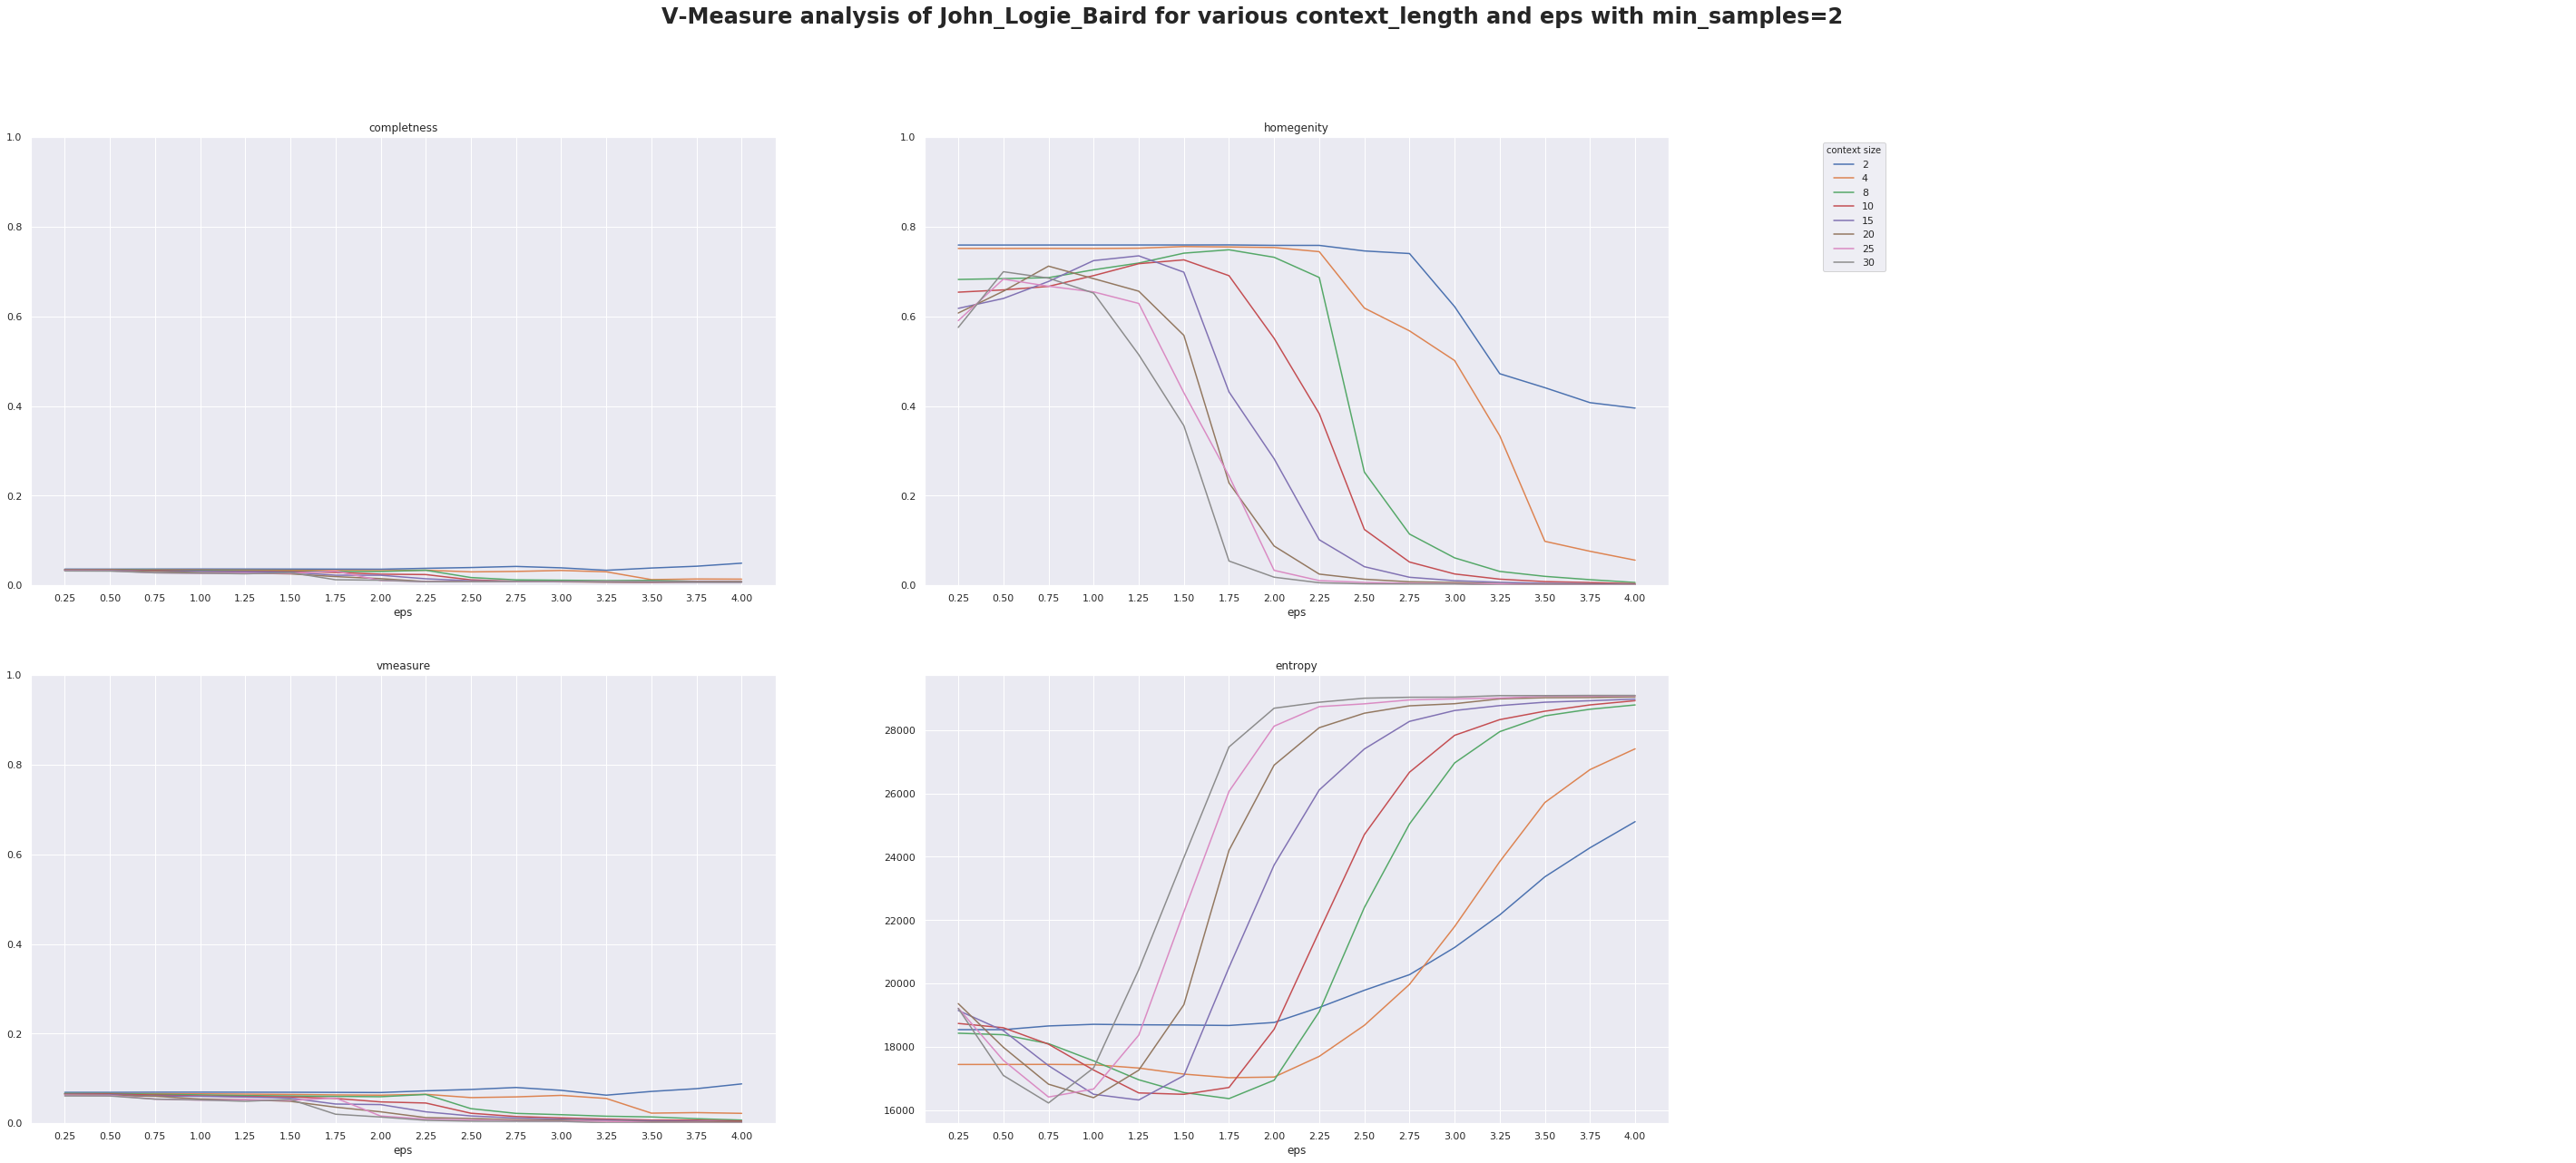

In [47]:
_df = evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"]).loc[2].reset_index()



cols = [
    'change_object_completness', 'change_object_homegenity', "Legend",
    "change_object_vmeasure", "gap_entropy",
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(50,20))

axes[0,0].set_ylim([0,1])
axes[0,1].set_ylim([0,1])
axes[1,0].set_ylim([0,1])
fig.suptitle(f'V-Measure analysis of John_Logie_Baird for various context_length and eps with min_samples=2 ', 
             fontsize=24 , fontweight="bold")


for i, column in enumerate(cols):
    if column =="Legend":
            
            handles, labels = _ax.get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')
            _ax = axes[int(i/3),i%3]
            _ax.legend(handles, labels, loc='upper left')
            _ax.axis('off')

    else:
#         _ax = axes[i]
        _ax = axes[int(i/3),i%3]


#         _ax.xaxis.label.set_visible(False)
#         _ax.legend(False)
        _ax.set_xlabel("eps")

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column.split("_")[-1],  xticks=eps_array, legend=False)

handles, labels = _ax.get_legend_handles_labels()
axes[0,2].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].legend(handles, labels, loc='upper left', title="context size",)


axes[0,2].axis('off')
axes[1,2].axis('off')

fig.savefig("visualisation/jlb-ours-co-2.png", dpi=600)


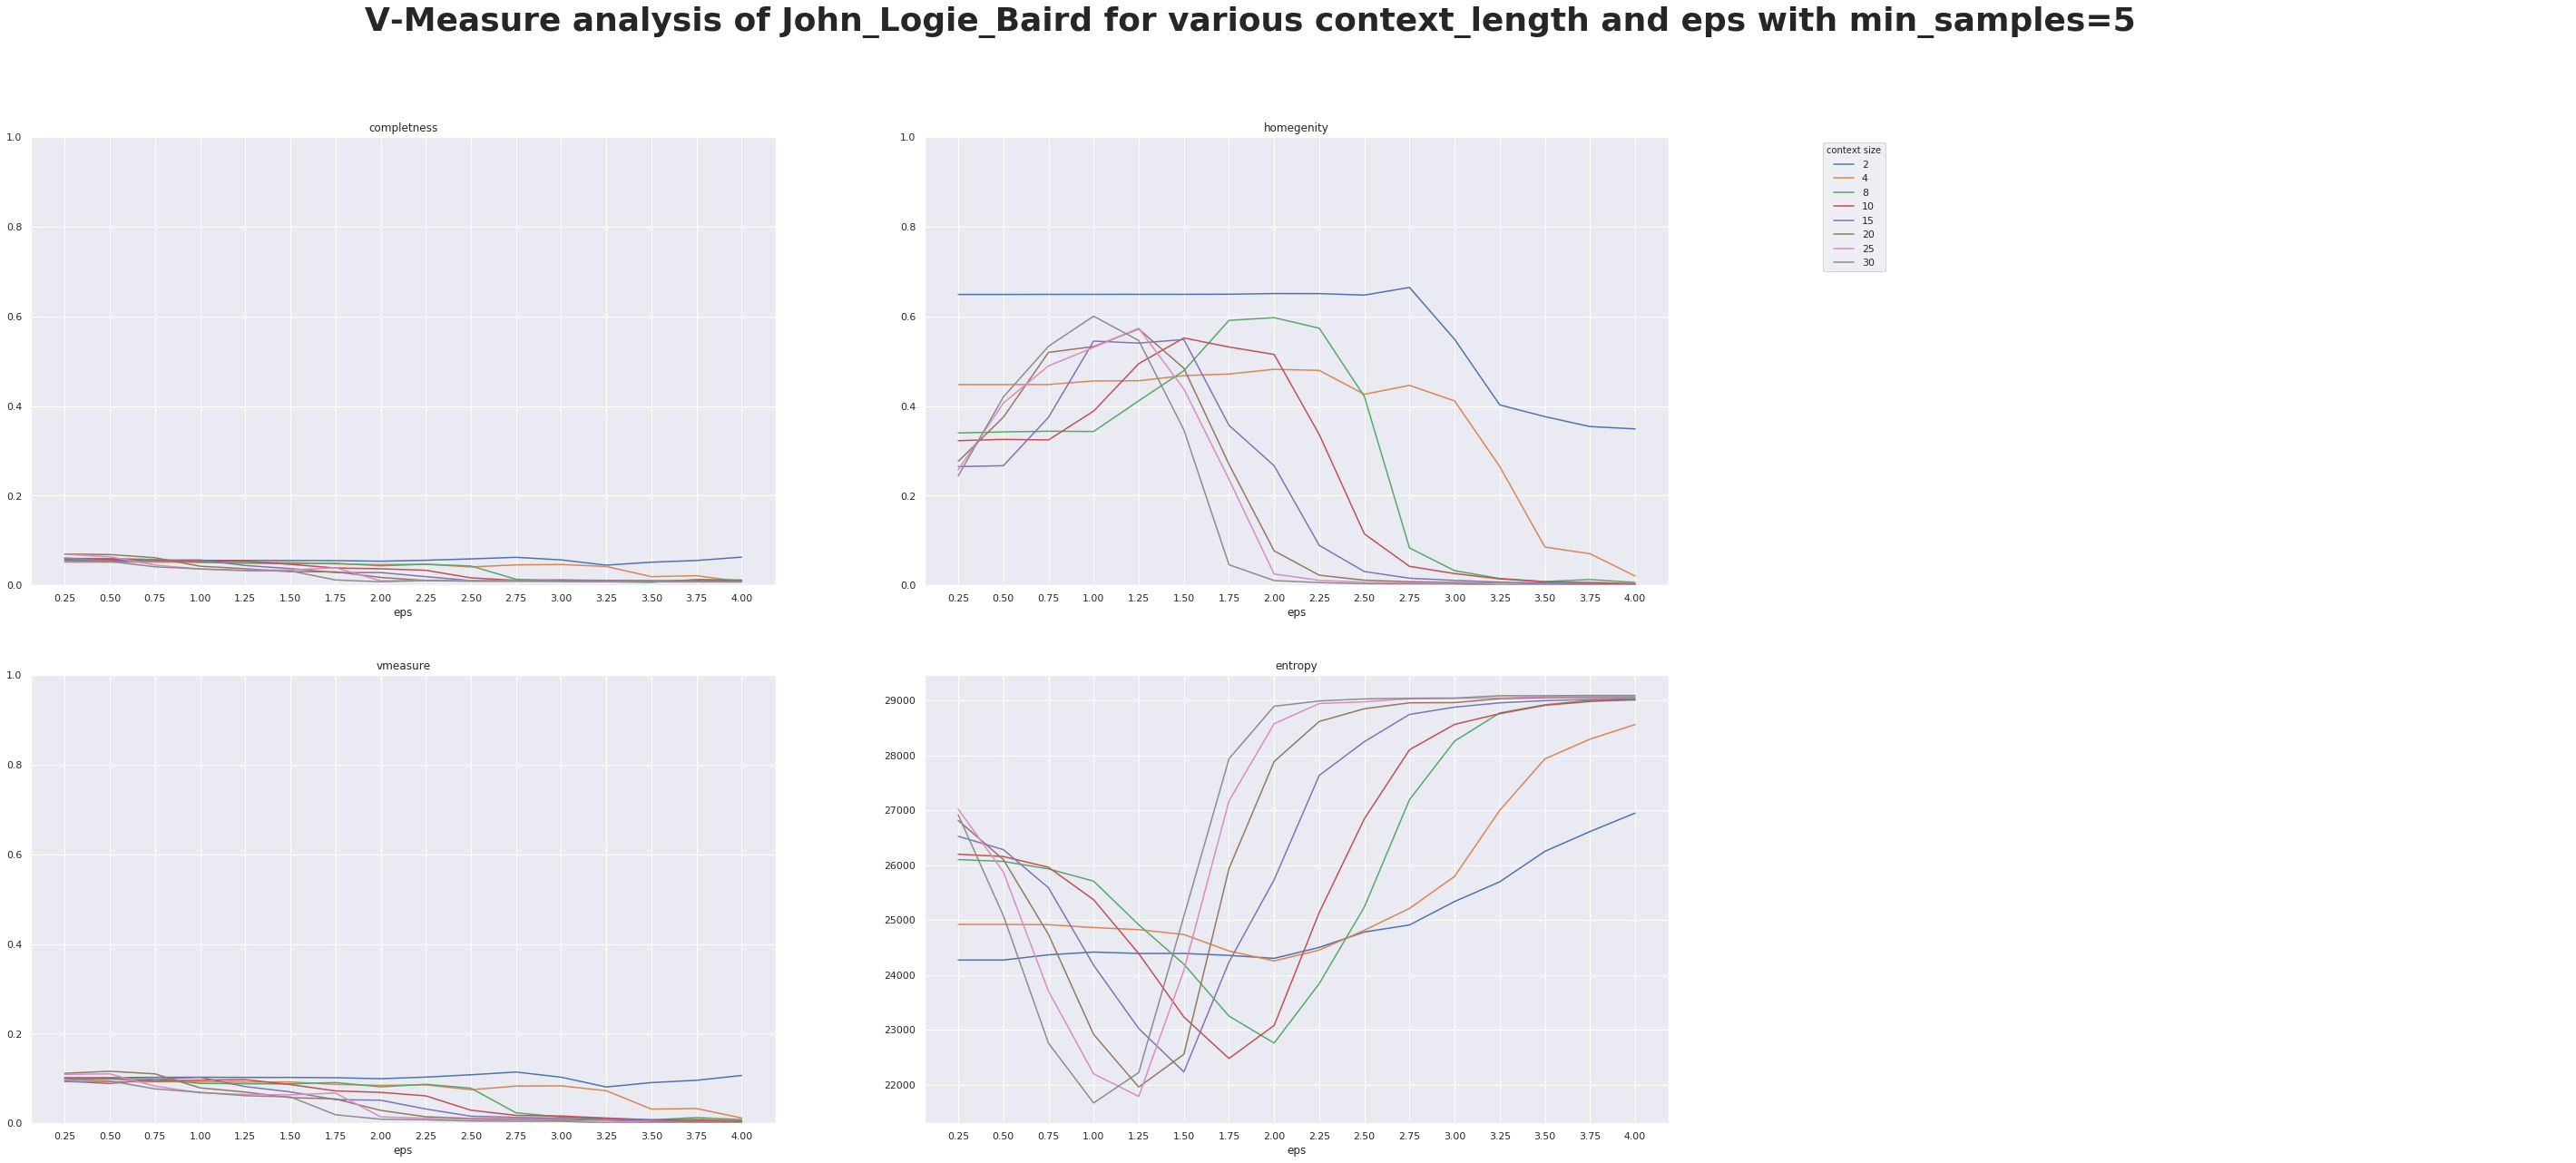

In [52]:
_df = evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"]).loc[5].reset_index()



cols = [
    'change_object_completness', 'change_object_homegenity', "Legend",
    "change_object_vmeasure", "gap_entropy",
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(50,20))
axes[0,0].set_ylim([0,1])
axes[0,1].set_ylim([0,1])
axes[1,0].set_ylim([0,1])
fig.suptitle(f'V-Measure analysis of John_Logie_Baird for various context_length and eps with min_samples=5 ', 
             fontsize=36, fontweight="bold")


for i, column in enumerate(cols):
    if column =="Legend":
            
            handles, labels = _ax.get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')
            _ax = axes[int(i/3),i%3]
            _ax.legend(handles, labels, loc='upper left')
            _ax.axis('off')

    else:
#         _ax = axes[i]
        _ax = axes[int(i/3),i%3]


#         _ax.xaxis.label.set_visible(False)
#         _ax.legend(False)
        _ax.set_xlabel("eps")

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column.split("_")[-1],  xticks=eps_array, legend=False)

handles, labels = _ax.get_legend_handles_labels()
axes[0,2].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].legend(handles, labels, loc='upper left', title="context size",)


axes[0,2].axis('off')
axes[1,2].axis('off')

fig.savefig("visualisation/jlb-ours-co-5.png", dpi=600)



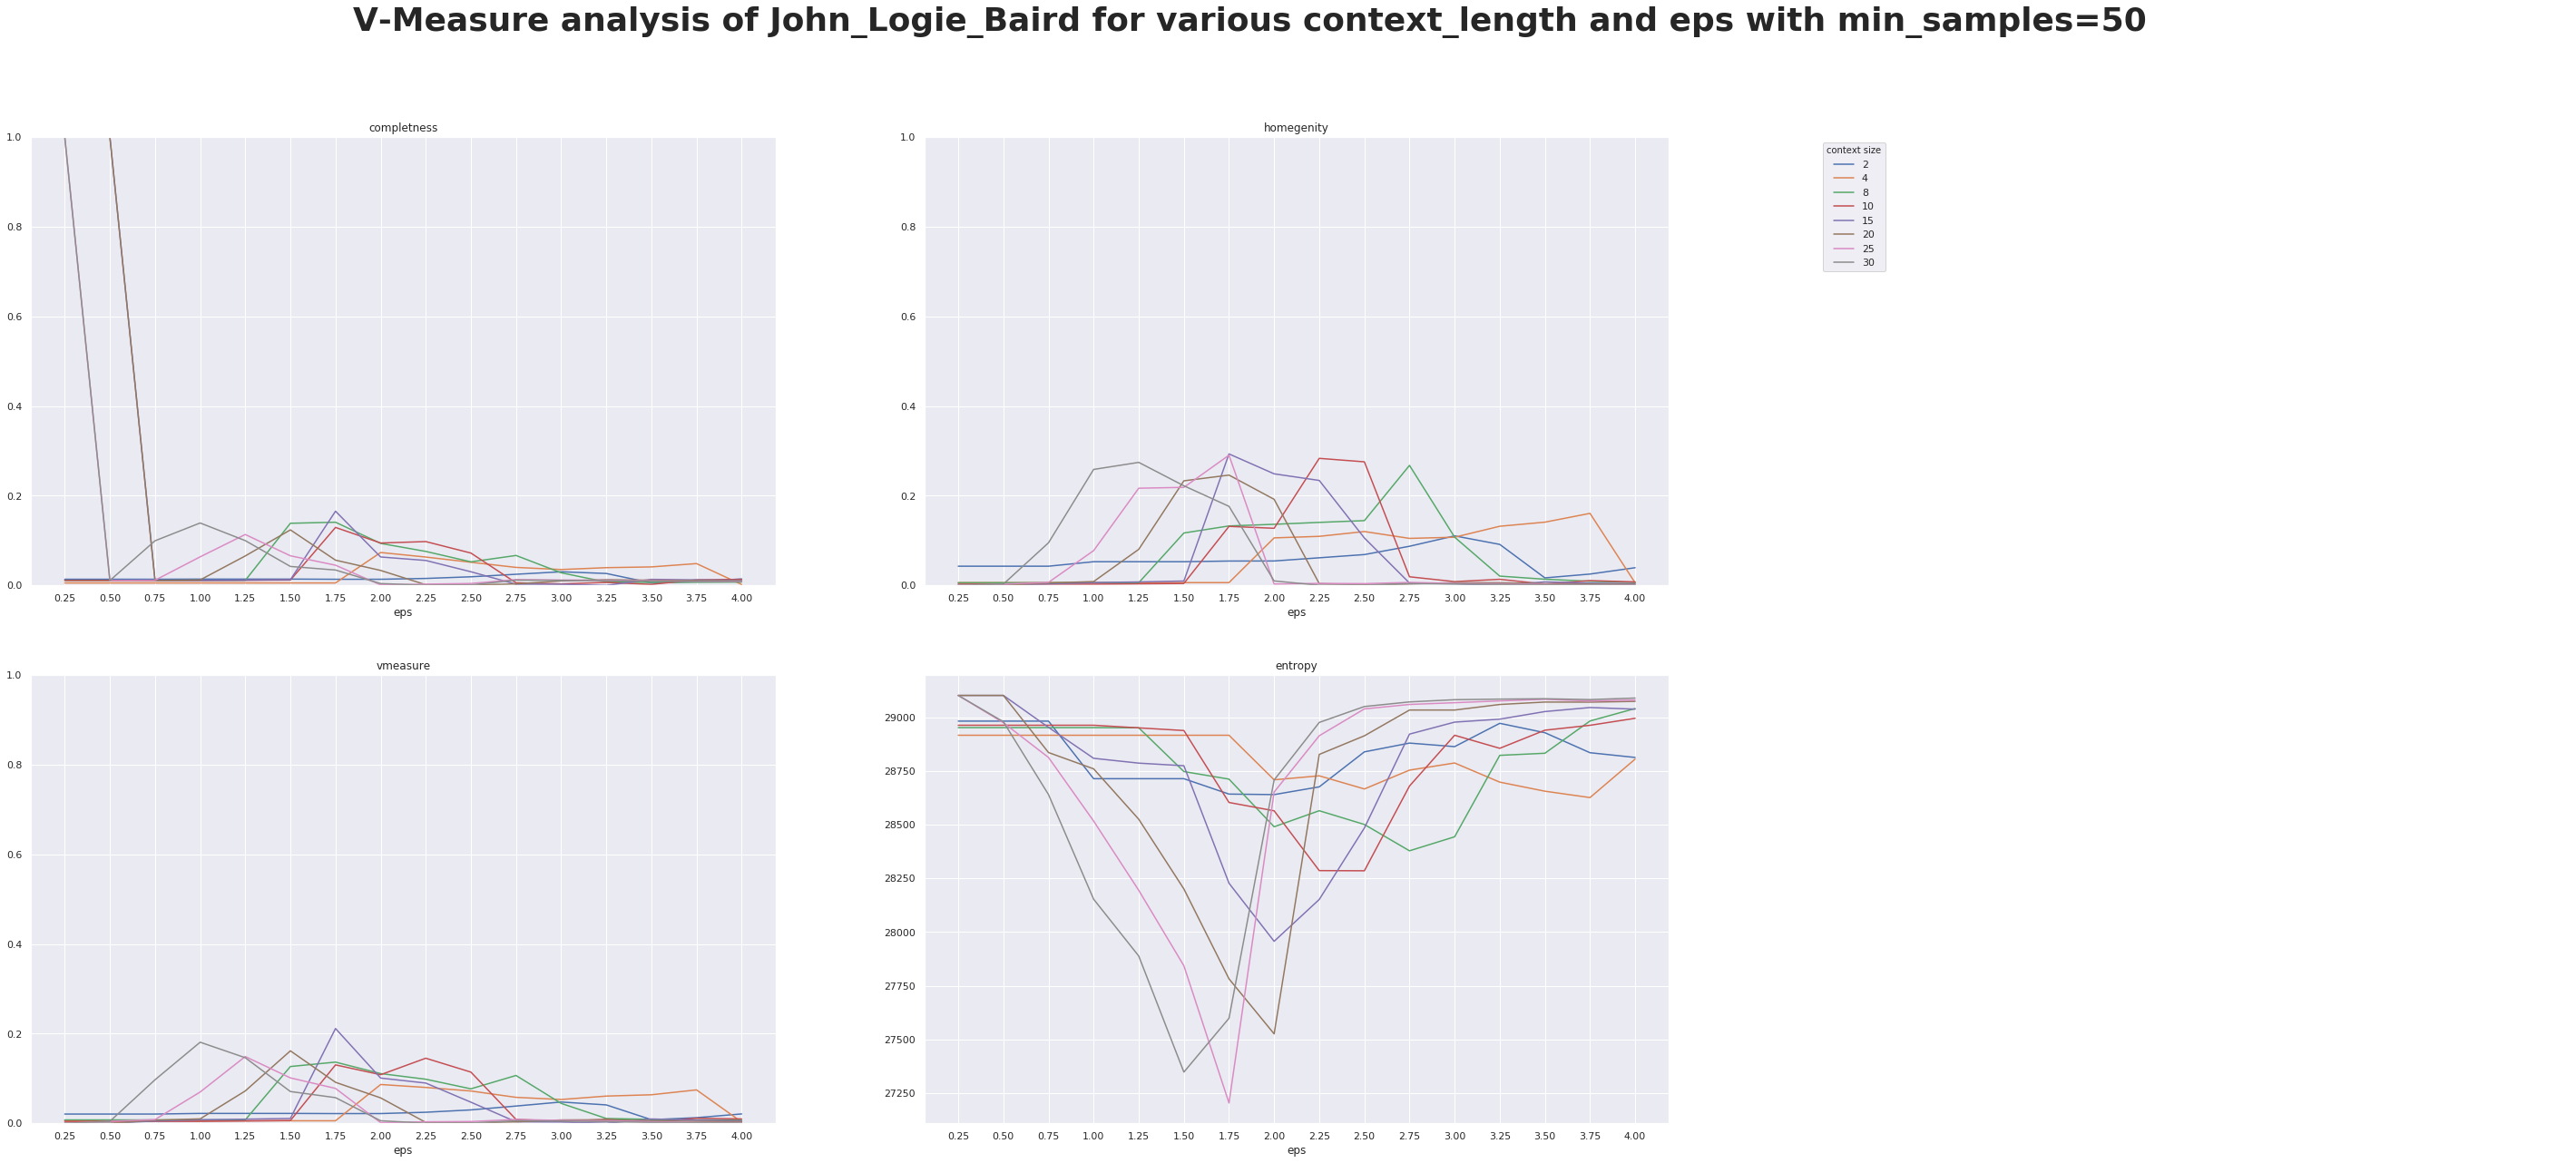

In [46]:
_df = evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"]).loc[50].reset_index()



cols = [
    'change_object_completness', 'change_object_homegenity', "Legend",
    "change_object_vmeasure", "gap_entropy",
]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(50, 20))
fig.suptitle(f'V-Measure analysis of John_Logie_Baird for various context_length and eps with min_samples=50 ', 
             fontsize=36, fontweight="bold")
axes[0,0].set_ylim([0,1])
axes[0,1].set_ylim([0,1])
axes[1,0].set_ylim([0,1])

for i, column in enumerate(cols):
    if column =="Legend":
            
            handles, labels = _ax.get_legend_handles_labels()
            #fig.legend(handles, labels, loc='lower right')
            _ax = axes[int(i/3),i%3]
            _ax.legend(handles, labels, loc='upper left')
            _ax.axis('off')

    else:
#         _ax = axes[i]
        _ax = axes[int(i/3),i%3]


#         _ax.xaxis.label.set_visible(False)
#         _ax.legend(False)
        _ax.set_xlabel("eps")

        for name2, subdf2 in _df.groupby(['context']): 
            subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column.split("_")[-1],  xticks=eps_array, legend=False)

handles, labels = _ax.get_legend_handles_labels()
axes[0,2].legend(handles, labels, loc='upper left', title="context size",)
# axes[3].legend(handles, labels, loc='upper left', title="context size",)


axes[0,2].axis('off')
axes[1,2].axis('off')

fig.savefig("visualisation/jlb-ours-co-50.png", dpi=600)




In [45]:
# _df = evaluation_df.reset_index().set_index(["min_samples", 
# "eps", "context"]).loc[5].reset_index()

# cols = [
#     'row_based_completness', 'row_based_homegenity', 'row_based_vmeasure',

# ]

# fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(24,5))

# axes[0,0].set_ylim([0,1])
# axes[0,1].set_ylim([0,1])
# axes[1,0].set_ylim([0,1])
# for i, column in enumerate(cols):
#     if column in _df.columns:
#         _ax = axes[i]
#         _ax.xaxis.label.set_visible(False)

#         for name2, subdf2 in _df.groupby(['context']): 
#             subdf2.plot(x = 'eps', y=column, ax=_ax, label=str(name2), title=column,  xticks=eps_array)

# handles, labels = _ax.get_legend_handles_labels()
# axes[3].legend(handles, labels, loc='upper left')
# axes[3].axis('off')


In [25]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_vmeasure"].sort_values().iloc[-20:]

min_samples  eps   context
10           0.75  20         0.138291
20           1.00  15         0.139809
             0.50  25         0.140026
             2.00  8          0.142325
50           2.25  10         0.145305
             1.25  30         0.146419
                   25         0.149015
10           0.50  25         0.151148
30           1.25  20         0.151203
             1.50  15         0.151319
             1.75  10         0.158541
50           1.50  20         0.161768
20           1.00  20         0.161951
             0.75  30         0.162756
30           2.00  10         0.167981
20           1.50  10         0.178480
50           1.00  30         0.181002
20           1.75  8          0.184867
                   10         0.189995
50           1.75  15         0.211560
Name: change_object_vmeasure, dtype: float64

In [26]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_completness"].sort_values().iloc[-20:]

min_samples  eps   context
20           1.00  20         0.107491
             0.75  30         0.108854
             0.50  25         0.110087
50           1.25  25         0.113529
30           1.75  10         0.114055
20           1.50  10         0.118690
             1.75  10         0.122932
50           1.50  20         0.123818
20           1.75  8          0.124046
50           1.75  10         0.129280
             1.50  8          0.138544
             1.00  30         0.139212
             1.75  8          0.140867
                   15         0.165477
             0.50  15         1.000000
             0.25  20         1.000000
                   15         1.000000
                   30         1.000000
             0.50  20         1.000000
             0.25  25         1.000000
Name: change_object_completness, dtype: float64

In [27]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_homegenity"].sort_values().iloc[-20:]

min_samples  eps   context
2            2.25  4          0.744382
             2.50  2          0.746018
             1.75  8          0.748599
             1.00  4          0.751478
             0.25  4          0.751578
             0.50  4          0.751578
             0.75  4          0.751639
             1.25  4          0.752128
             2.00  4          0.753664
             1.75  4          0.754895
             1.50  4          0.755845
             2.25  2          0.758391
             2.00  2          0.758478
             0.25  2          0.759180
             0.50  2          0.759180
             0.75  2          0.759226
             1.00  2          0.759246
             1.25  2          0.759288
             1.50  2          0.759340
             1.75  2          0.759477
Name: change_object_homegenity, dtype: float64

In [28]:
evaluation_df.reset_index().set_index([  "min_samples", "context", "eps", ]).loc[2]["change_object_homegenity"].sort_values().iloc[-10:]

context  eps 
4        1.50    0.755845
2        2.25    0.758391
         2.00    0.758478
         0.50    0.759180
         0.25    0.759180
         0.75    0.759226
         1.00    0.759246
         1.25    0.759288
         1.50    0.759340
         1.75    0.759477
Name: change_object_homegenity, dtype: float64

In [29]:
evaluation_df.reset_index().set_index([ "min_samples", "context", "eps", ]).loc[2]["change_object_completness"].sort_values().iloc[-10:]

context  eps 
2        1.25    0.036426
         0.75    0.036429
         1.00    0.036478
         2.25    0.038086
         3.50    0.038735
         3.00    0.039157
         2.50    0.039841
         2.75    0.042287
         3.75    0.042746
         4.00    0.049520
Name: change_object_completness, dtype: float64

In [30]:
evaluation_df.reset_index().set_index(["min_samples", "context", "eps", ]).loc[2]["change_object_vmeasure"].sort_values().iloc[-10:]

context  eps 
2        1.25    0.069518
         0.75    0.069522
         1.00    0.069611
         3.50    0.071215
         2.25    0.072529
         3.00    0.073675
         2.50    0.075642
         3.75    0.077378
         2.75    0.080003
         4.00    0.088018
Name: change_object_vmeasure, dtype: float64

In [31]:
evaluation_df.reset_index().set_index([ "eps",  "min_samples", "context"]).loc[0.8,2,15]

KeyError: 'the label [0.8] is not in the [index]'

In [ ]:
evaluation_df.reset_index().set_index([ "eps",  "min_samples", "context"]).loc[0.5,10,2]

### Example of best groups

In [ ]:
pd.set_option('display.max_colwidth', 860)

In [ ]:
dbscan_results.groupby((15,0.8,2,)).get_group(df3.groupby((15,0.8,2,))["token_id"].size().sort_values(ascending=False).index[2]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]



In [ ]:
dbscan_results.groupby((30,0.3,50)).get_group(df3.groupby((30,0.3,50))["token_id"].size().sort_values(ascending=False).index[0]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]



In [ ]:
dbscan_results.groupby((30,0.4,10)).get_group(df3.groupby((30,0.4,10))["token_id"].size().sort_values(ascending=False).index[4]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
dbscan_results.groupby((30,0.4,10)).get_group(df3.groupby((30,0.4,10))["token_id"].size().sort_values(ascending=False).index[1]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

### Very tight cluster

In [ ]:
df3.groupby((30,0.4,10,)).get_group(df3.groupby((30,0.4,10,))["token_id"].size().sort_values(ascending=False).index[4]).reset_index()[["nationality", "nationality_full"]]

In [ ]:
dbscan_results.groupby((30,0.4,10,)).get_group(df3.groupby((30,0.4,10,))["token_id"].size().sort_values(ascending=False).index[4]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]


In [ ]:
dbscan_results.groupby((15,0.5,2,)).get_group(df3.groupby((15,0.5,2,))["token_id"].size().sort_values(ascending=False).index[7]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
dbscan_results.groupby((2,0.5,10,)).get_group(df3.groupby((2,0.5,10,))["token_id"].size().sort_values(ascending=False).index[10]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
dbscan_results.groupby((2,0.5,10,)).get_group(df3.groupby((2,0.5,10,))["token_id"].size().sort_values(ascending=True).index[7]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

# Identifying worst clusters

In [ ]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_vmeasure"].sort_values().iloc[0:20]

In [ ]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_completness"].sort_values().iloc[0:20]

In [ ]:
evaluation_df.reset_index().set_index(["min_samples", 
"eps", "context"])["change_object_homegenity"].sort_values().iloc[0: 30]

In [ ]:
evaluation_df.reset_index().set_index([ "eps",  "min_samples", "context"]).loc[1.6]["change_object_homegenity"].sort_values().iloc[0:10]

In [ ]:
evaluation_df.reset_index().set_index([ "eps",  "min_samples", "context"]).loc[2.0]["change_object_completness"].sort_values().iloc[:10]

In [ ]:
evaluation_df.reset_index().set_index([ "eps",  "min_samples", "context"]).loc[2.0]["change_object_vmeasure"].sort_values().iloc[:10]

In [ ]:
dbscan_results.groupby((30,2.0,2)).get_group(df3.groupby((30,2.0,2))["token_id"].size().sort_values(ascending=False).index[6]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
dbscan_results.groupby((30,1.6,2)).get_group(df3.groupby((30,1.6,2))["token_id"].size().sort_values().index[145]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
dbscan_results.groupby((30,1.6,2)).get_group(df3.groupby((30,1.6,2))["token_id"].size().sort_values().index[130]).reset_index()[[ 'left_context',
     'del_string_tokens',  'ins_string_tokens',   'right_context']]

In [ ]:
pd.set_option('expand_frame_repr', False)
pd.reset_option('display.max_colwidth')

In [ ]:
dbscan_results.columns[:20]

In [ ]:
dbscan_results.head(2)["right_neigh"]